# Plot layer with maximum energy, overlaid at rechits, CLUE2D and CLUE3D levels

In [1]:
import sys
from dataclasses import dataclass
from enum import Enum, auto

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

sys.path.append("..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies, synchrotronBeamEnergiesMap
from hists.store import HistogramId

In [2]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v43'
#clueParams = "single-file"
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)

In [3]:
class Level(Enum):
    RECHITS = auto()
    CLUSTER_2D = auto()
    CLUSTER_3D = auto()

@dataclass
class PlotInfo:
    beamEnergy:int
    datatype:str

In [4]:
def getHist(info:PlotInfo, level:Level, profile=False):
    if profile:
        projections = {}
    else:
        projections = {
            "beamEnergy": hist.loc(info.beamEnergy),
        }
    if level is Level.RECHITS:
        if profile:
            h_name = "RechitsMeanLayerWithMaximumEnergy"
        else:
            h_name = "RechitsLayerWithMaximumEnergy"
        projectOn = "rechits_layer"
    elif level is Level.CLUSTER_2D:
        if profile:
            h_name = "MeanLayerWithMaximumClustered2DEnergy"
        else:
            h_name = "LayerWithMaximumClustered2DEnergy"
        projectOn = "clus2D_layer"
    elif level is Level.CLUSTER_3D:
        if profile:
            h_name = "Clus3DMeanLayerWithMaximumClusteredEnergy"
        else:
            h_name = "Clus3DLayerWithMaximumClusteredEnergy"
        projectOn = "layer_with_max_clustered_energy"
        projections["mainOrAllTracksters"] = hist.loc("mainTrackster")
    else:
        assert(False)
    if profile:
        projectOn = "beamEnergy_custom"
        kind = HistogramKind.PROFILE
    else:
        kind = HistogramKind.COUNT
    h = (histStore
        .get(HistogramId(h_name, clueParams, info.datatype))
        .getHistogram(kind))
    if len(projections) > 0:
        h = h[projections]
    return h.project(projectOn)

In [5]:
getHist(PlotInfo(datatype="data", beamEnergy=20), level=Level.CLUSTER_3D,profile=True)

Hist(IntCategory([20, 30, 50, 80, 100, 120, 150, 200, 250, 300], name='beamEnergy_custom', label='Beam energy (GeV)'), storage=Mean()) # Sum: Mean(count=270055, value=8.50594, variance=3.64383)

In [6]:
def makePlotLayerDistribution(h_rechits, h_2D, h_3D, plotInfo:PlotInfo):
    plt.figure()
    plt.xlabel("Layer")
    plt.ylabel("Event count")
    
    hep.histplot([h_rechits, h_2D, h_3D], yerr=False, label=["Rechits", "Layer cluster", "CLUE3D trackster\n(main trackster only)"])

    plt.xlim(1, 16)
    if plotInfo.datatype == "data":
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext("$e^+$ " + str(plotInfo.beamEnergy) + " GeV")
    plt.legend()

def makePlotProfile(h_rechits, h_2D, h_3D, plotInfo:PlotInfo, ax=None, lumi=True,
        plot_kwargs:dict[str, str]=dict(fmt='o-'), individual_plot_kwargs:list[dict]=None, appendDataSim=False, legend=True, alphaForMakersOnly:float|None=None):
    """ alphaForMakersOnly : if set to float, will apply alpha to markers and not lines (do not specify alpha in plot_kwargs in this case)"""
    if ax is None:
        fig, ax = plt.subplots()
    plot_kwargs = plot_kwargs.copy()
    fmt = plot_kwargs.pop("fmt")
    labels = ["Rechits", "CLUE", "CLUE3D main trackster"]
    if appendDataSim:
        for i in range(len(labels)):
            if plotInfo.datatype == "data":
                labels[i] += " (Data)"
            else:
                labels[i] += " (Simulation)"
    if individual_plot_kwargs is None:
        individual_plot_kwargs = [dict() for _ in labels]
    for h, label, individual_plot_kwargs_cur in zip([h_rechits, h_2D, h_3D], labels,
                individual_plot_kwargs):
        l, = ax.plot([synchrotronBeamEnergiesMap[h.axes[0].bin(i)] for i in range(h.axes[0].size)], h.view(flow=False).value, fmt, label=label,
            **(plot_kwargs | individual_plot_kwargs_cur))
        if alphaForMakersOnly is not None:
            l.set_markerfacecolor(matplotlib.colors.to_rgba(l.get_markerfacecolor(), alphaForMakersOnly)) #(plot_kwargs | individual_plot_kwargs_cur)["color"]
            l.set_markeredgecolor(matplotlib.colors.to_rgba(l.get_markeredgecolor(), alphaForMakersOnly))


    ax.set_xlabel("Incident beam energy (GeV)")
    ax.set_ylabel("Mean layer with maximum energy")
    ax.set_xticks([h.axes[0].bin(i) for i in range(h.axes[0].size)])
    ax.xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
    if legend:
        ax.legend()
    if not lumi:
        return
    if plotInfo.datatype == "data":
        hep.cms.text("Preliminary", ax=ax)
    else:
        hep.cms.text("Simulation Preliminary", ax=ax)
    hep.cms.lumitext("$e^+$ test beam", ax=ax)
    

## Distribution of layer with max energy

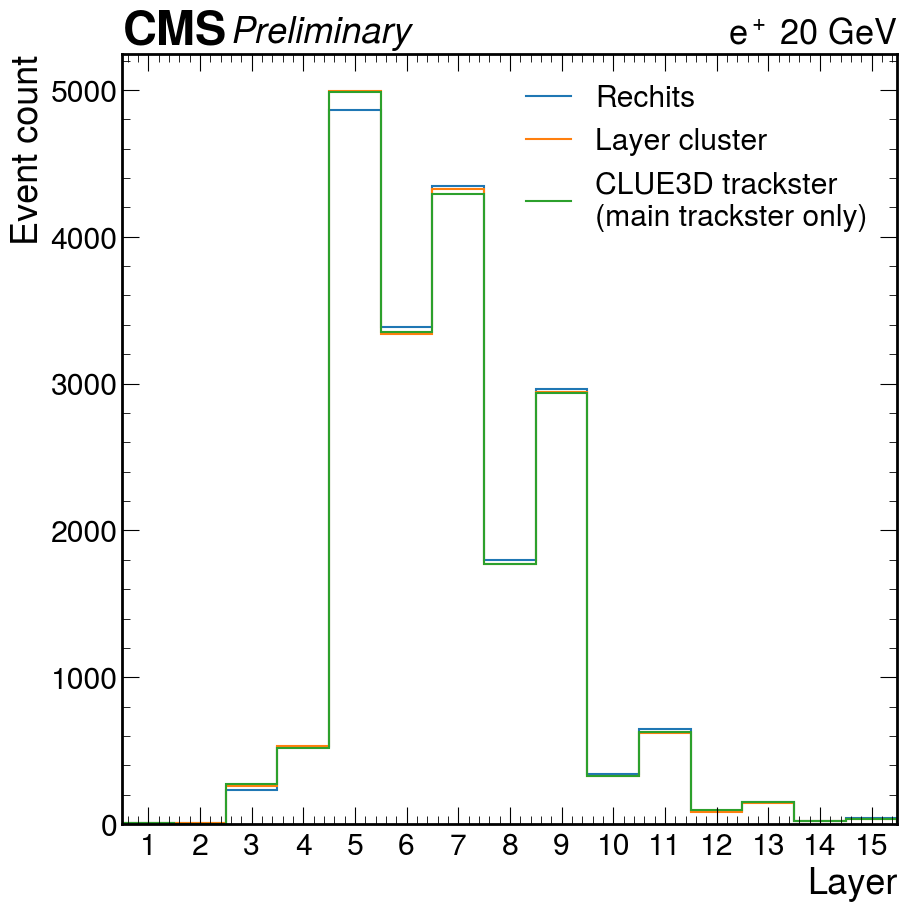

In [7]:
plotInfo = PlotInfo(datatype="data", beamEnergy=20)
makePlotLayerDistribution(*(getHist(plotInfo, level) for level in Level), plotInfo=plotInfo)

## Profile of layer with max energy, fct of beam energy

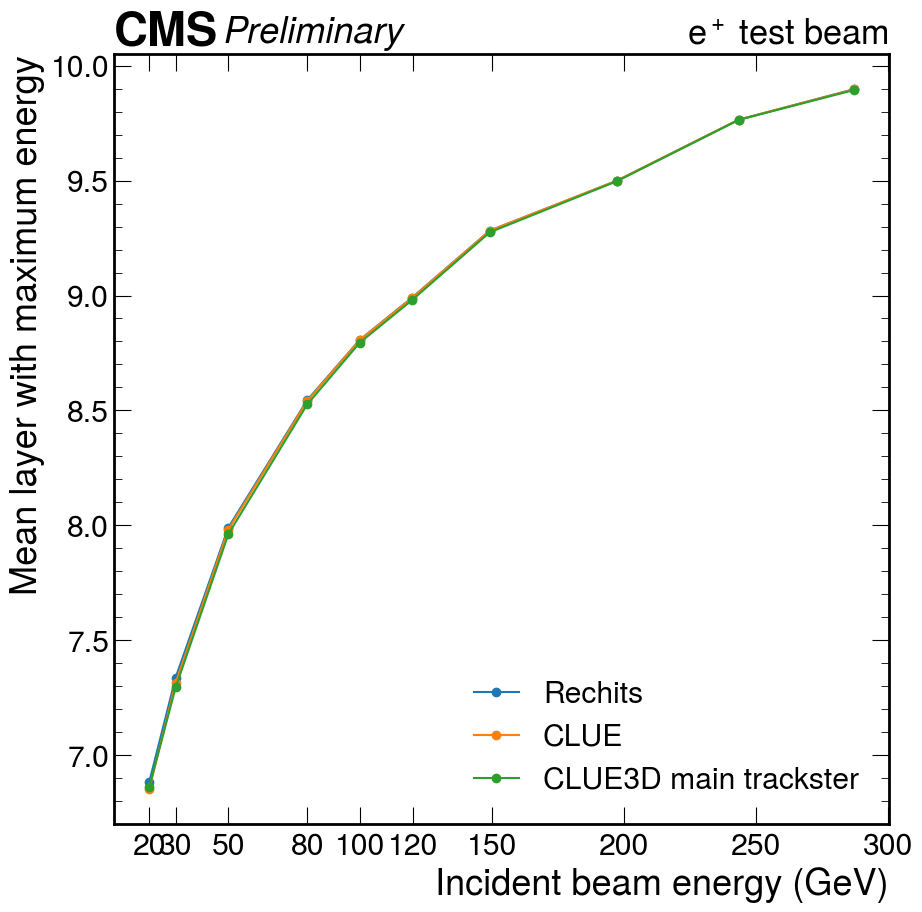

In [8]:
plotInfo = PlotInfo(datatype="data", beamEnergy=None)
makePlotProfile(*(getHist(plotInfo, level, profile=True) for level in Level), plotInfo=plotInfo)

version for approval

/tmp/ipykernel_28424/3726250211.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  l, = ax.plot([synchrotronBeamEnergiesMap[h.axes[0].bin(i)] for i in range(h.axes[0].size)], h.view(flow=False).value, fmt, label=label,
/tmp/ipykernel_28424/3726250211.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o--" (-> marker='o'). The keyword argument will take precedence.
  l, = ax.plot([synchrotronBeamEnergiesMap[h.axes[0].bin(i)] for i in range(h.axes[0].size)], h.view(flow=False).value, fmt, label=label,


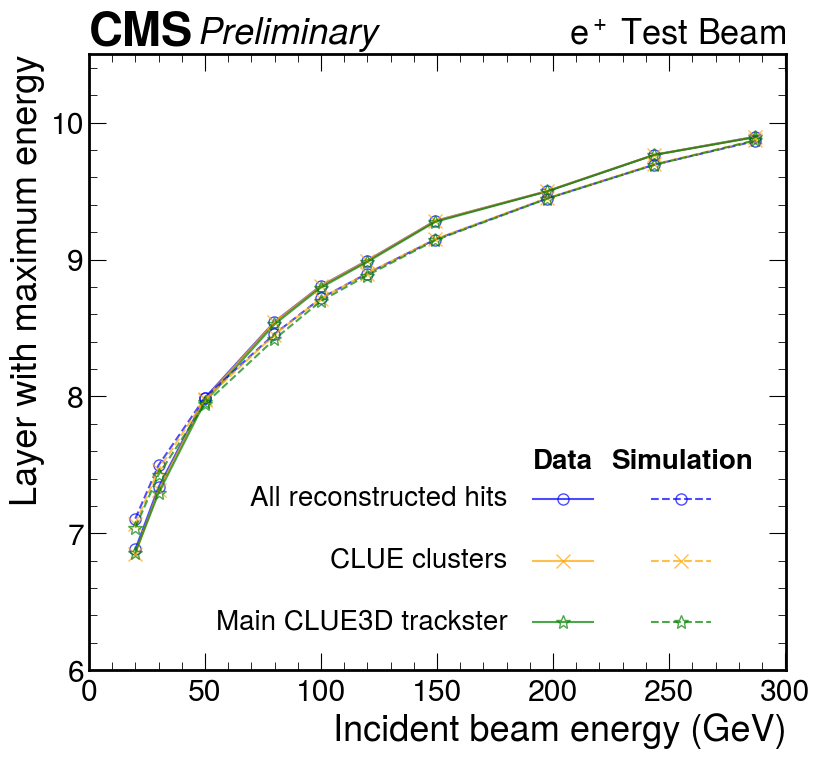

In [9]:
fig, ax = plt.subplots(figsize=(9, 8))
common_kwargs = dict(individual_plot_kwargs=[dict(color="blue", fillstyle="none", markersize=8), dict(color="orange", marker="x", markersize=10), dict(color="green", marker="*", fillstyle="none", markersize=10)],
    ax=ax, appendDataSim=True,  legend=False)
plotInfo = PlotInfo(datatype="data", beamEnergy=None)
makePlotProfile(*(getHist(plotInfo, level, profile=True) for level in Level), plotInfo=plotInfo, lumi=False, plot_kwargs=dict(fmt="o-", alpha=0.7), **common_kwargs)
plotInfo = PlotInfo(datatype="sim_proton_v46_patchMIP", beamEnergy=None)
makePlotProfile(*(getHist(plotInfo, level, profile=True) for level in Level), plotInfo=plotInfo, lumi=False, plot_kwargs=dict(fmt="o--", alpha=0.7),
    **common_kwargs)
hep.cms.text("Preliminary", loc=0)
hep.cms.lumitext("$e^+$ Test Beam")
# plt.text(
#     s="$e^+$ Test Beam",
#     transform=plt.gca().transAxes,
#     ha="left",
#     fontsize=matplotlib.rcParams["font.size"] * 0.95,
#     fontweight="normal",
#     fontname="TeX Gyre Heros",
#     x=0.05, y=0.82, 
# )

plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.ylabel("Layer with maximum energy")
plt.ylim(6, 10.5)

#for tick in plt.gca().xaxis.get_major_ticks()[1:6:2]:
#    tick.set_pad(25)
#plt.gca().xaxis.labelpad=-10
plt.gca().xaxis.set_major_locator(matplotlib.ticker.AutoLocator())
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator()) 
plt.xlim(left=0)

yBottom = -0.02
legendKw = dict(handleheight=2, handlelength=2)
leg1 = plt.legend(handles=plt.gca().get_legend_handles_labels()[0][:3], labels=[None]*3, loc="lower right", bbox_to_anchor=(0.8, yBottom), **legendKw)
plt.gca().add_artist(leg1)
plt.legend(handles=plt.gca().get_legend_handles_labels()[0][3:], labels=[None]*3, loc="lower right", bbox_to_anchor=(0.97, yBottom), **legendKw)
textKw = dict(transform=plt.gca().transAxes, fontsize=20, ha="right", va="top")
textyBottom = yBottom+0.12
textVertPad = 0.1
plt.text(x=0.6, y=textyBottom+2*textVertPad, s="All reconstructed hits", **textKw)
plt.text(x=0.6, y=textyBottom+textVertPad, s="CLUE clusters", **textKw)
plt.text(x=0.6, y=textyBottom, s="Main CLUE3D trackster", **textKw)
plt.text(x=0.68, y=yBottom+0.38, ha="center", va="top", fontsize=20, transform=plt.gca().transAxes, s="Data", weight="bold")
plt.text(x=0.85, y=yBottom+0.38, ha="center", va="top", fontsize=20, transform=plt.gca().transAxes, s="Simulation", weight="bold")
plt.savefig("plots/layerWithMaxEnergy.pdf", bbox_inches="tight")

With ratio plot

/tmp/ipykernel_28424/3726250211.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  l, = ax.plot([synchrotronBeamEnergiesMap[h.axes[0].bin(i)] for i in range(h.axes[0].size)], h.view(flow=False).value, fmt, label=label,
/tmp/ipykernel_28424/3726250211.py:34: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o--" (-> marker='o'). The keyword argument will take precedence.
  l, = ax.plot([synchrotronBeamEnergiesMap[h.axes[0].bin(i)] for i in range(h.axes[0].size)], h.view(flow=False).value, fmt, label=label,
/tmp/ipykernel_28424/727834136.py:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  subplot_ax.plot([synchrotronBeamEnergiesMap[h_data.axes[0].bin(i)] for i in range(h_data.axes[0].size)], h_data.values() / h_s

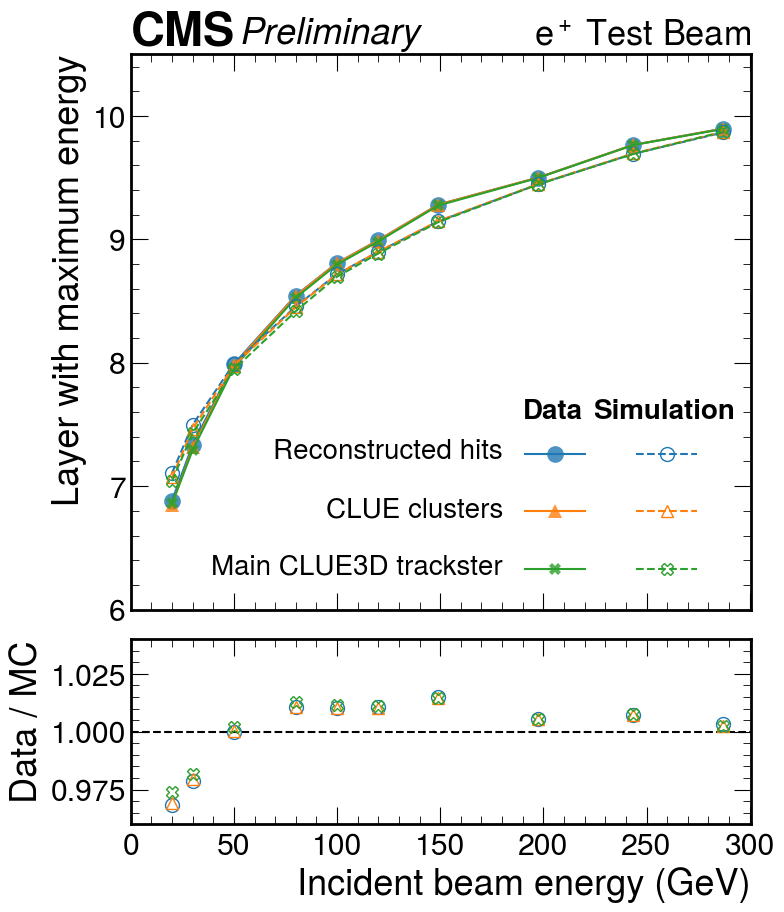

In [10]:
fig = plt.figure(figsize=(8, 10))
grid = fig.add_gridspec(2, 1, hspace=0.08, height_ratios=[3, 1])

main_ax = fig.add_subplot(grid[0])
subplot_ax = fig.add_subplot(grid[1], sharex=main_ax)
plt.setp(main_ax.get_xticklabels(), visible=False)
subplot_ax.axhline(1, color="black", linestyle="--")

common_kwargs = dict(ax=main_ax, appendDataSim=True,  legend=False)
plot_kwargs_data = [dict(color="tab:blue", fillstyle="full", markersize=12), dict(color="tab:orange", marker="^", fillstyle="full",  markersize=10), dict(color="tab:green", marker="X", markersize=8)]
plot_kwargs_sim = [dict(color="tab:blue", fillstyle="none", markersize=10), dict(color="tab:orange", marker="^", fillstyle="none",  markersize=9), dict(color="tab:green", marker="X", fillstyle="none", markersize=8)]
plotInfo = PlotInfo(datatype="data", beamEnergy=None)
makePlotProfile(*(getHist(plotInfo, level, profile=True) for level in Level), plotInfo=plotInfo, lumi=False, plot_kwargs=dict(fmt="o-", markeredgewidth=0), alphaForMakersOnly=0.8, **common_kwargs, individual_plot_kwargs=plot_kwargs_data)
plotInfo = PlotInfo(datatype="sim_proton_v46_patchMIP", beamEnergy=None)
makePlotProfile(*(getHist(plotInfo, level, profile=True) for level in Level), plotInfo=plotInfo, lumi=False, plot_kwargs=dict(fmt="o--", markeredgewidth=1), **common_kwargs, individual_plot_kwargs=plot_kwargs_sim),

for level, kwargs_data in zip(Level, plot_kwargs_sim):
    h_data = getHist(PlotInfo(datatype="data", beamEnergy=None), level, profile=True)
    h_sim = getHist(PlotInfo(datatype="sim_proton_v46_patchMIP", beamEnergy=None), level, profile=True)
    subplot_ax.plot([synchrotronBeamEnergiesMap[h_data.axes[0].bin(i)] for i in range(h_data.axes[0].size)], h_data.values() / h_sim.values(), "o", **kwargs_data, linestyle="none")

hep.cms.text("Preliminary", loc=0, ax=main_ax)
hep.cms.lumitext("$e^+$ Test Beam", ax=main_ax)

main_ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
main_ax.set_ylabel("Layer with maximum energy")
main_ax.set_ylim(6, 10.5)
subplot_ax.set_ylim(0.96, 1.04)
subplot_ax.set_ylabel("Data / MC")

#for tick in plt.gca().xaxis.get_major_ticks()[1:6:2]:
#    tick.set_pad(25)
#plt.gca().xaxis.labelpad=-10
subplot_ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(50))
subplot_ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator()) 
subplot_ax.set_xlim(left=0)
main_ax.set_xlabel("")
subplot_ax.set_xlabel("Incident beam energy (GeV)")

yBottom = -0.03
legendKw = dict(handleheight=1.8, handlelength=2)
leg1 = main_ax.legend(handles=main_ax.get_legend_handles_labels()[0][:3], labels=[None]*3, loc="lower right", bbox_to_anchor=(0.82, yBottom), **legendKw)
main_ax.add_artist(leg1)
main_ax.legend(handles=main_ax.get_legend_handles_labels()[0][3:], labels=[None]*3, loc="lower right", bbox_to_anchor=(1.0, yBottom), **legendKw)
textKw = dict(transform=main_ax.transAxes, fontsize=20, ha="right", va="top")
textyBottom = yBottom+0.13
textVertPad = 0.104
main_ax.text(x=0.6, y=textyBottom+2*textVertPad, s="Reconstructed hits", **textKw)
main_ax.text(x=0.6, y=textyBottom+textVertPad, s="CLUE clusters", **textKw)
main_ax.text(x=0.6, y=textyBottom, s="Main CLUE3D trackster", **textKw)
main_ax.text(x=0.68, y=yBottom+0.41, ha="center", va="top", fontsize=20, transform=main_ax.transAxes, s="Data", weight="bold")
main_ax.text(x=0.86, y=yBottom+0.41, ha="center", va="top", fontsize=20, transform=main_ax.transAxes, s="Simulation", weight="bold")


plt.savefig("plots/layerWithMaxEnergy-ratio.pdf", bbox_inches="tight")

### Rechits, compare data and simulations

In [11]:
def makePlotProfileSameLevel(hists:dict[str, hist.Hist], ax=None, lumi=True,
        plot_kwargs:dict[str, str]=dict(fmt='o-'), individual_plot_kwargs:list[dict]=None):
    if ax is None:
        fig, ax = plt.subplots()
    plot_kwargs = plot_kwargs.copy()
    fmt = plot_kwargs.pop("fmt")

    if individual_plot_kwargs is None:
        individual_plot_kwargs = [dict() for _ in hists]
    
    for (datatype, h), individual_plot_kwargs_cur in zip(hists.items(), individual_plot_kwargs):
        ax.plot([h.axes[0].bin(i) for i in range(h.axes[0].size)], h.view(flow=False).value, fmt, label=datatype,
            **(plot_kwargs | individual_plot_kwargs_cur))

    ax.set_xlabel("Beam energy (GeV)")
    ax.set_ylabel("Mean layer with maximum energy")
    ax.set_xticks([h.axes[0].bin(i) for i in range(h.axes[0].size)])
    ax.xaxis.set_minor_locator(matplotlib.ticker.NullLocator())
    ax.legend()
    if not lumi:
        return
    if plotInfo.datatype == "data":
        hep.cms.text("Preliminary", ax=ax)
    else:
        hep.cms.text("Simulation Preliminary", ax=ax)
    hep.cms.lumitext("$e^+$ test beam", ax=ax)
    

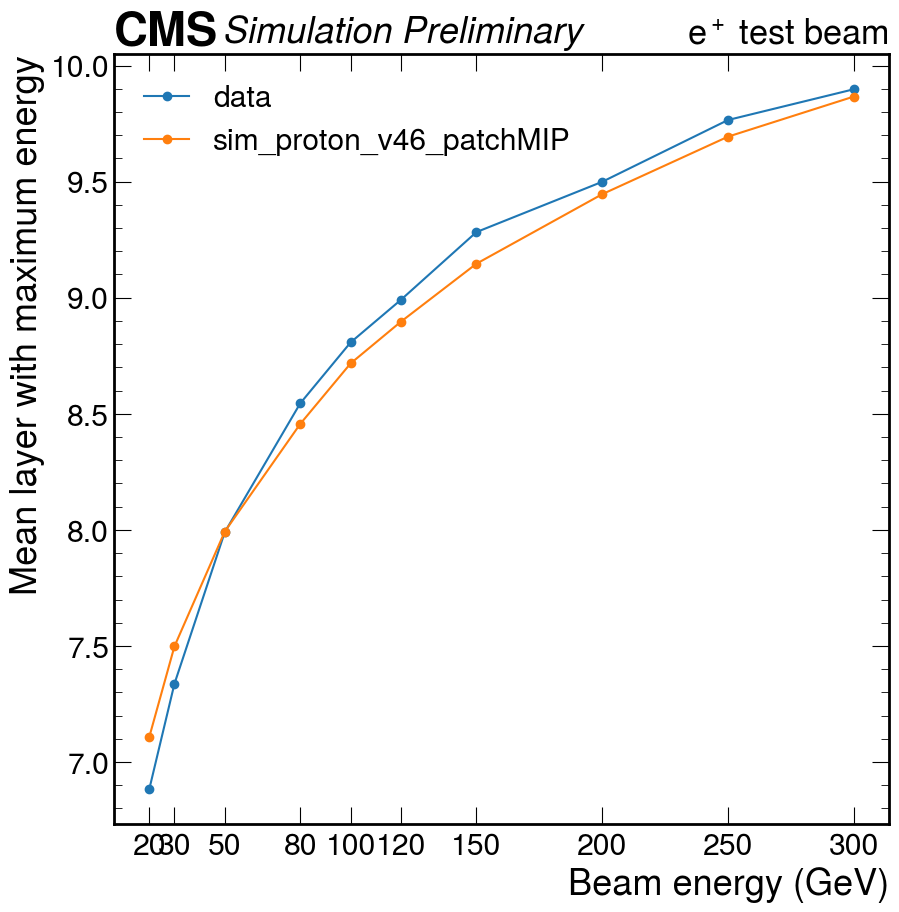

In [12]:
hists = {}
for datatype in ["data", "sim_proton_v46_patchMIP"]:
    hists[datatype] = getHist(PlotInfo(None, datatype), Level.RECHITS, profile=True)
makePlotProfileSameLevel(hists)

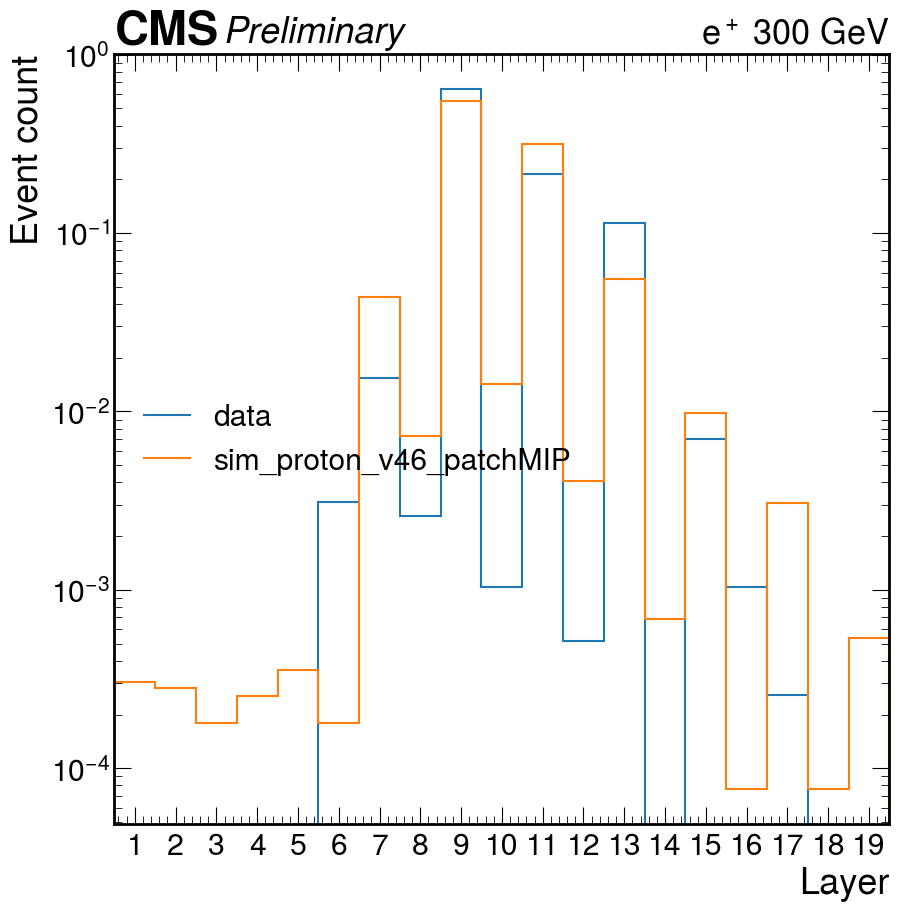

In [13]:
def makePlotLayerDistributionSameLevel(hists:dict[str, hist.Hist], beamEnergy):
    plt.figure()
    plt.xlabel("Layer")
    plt.ylabel("Event count")
    
    hep.histplot(list(hists.values()), yerr=False, label=hists.keys(), density=True)

    plt.xlim(1, 20)
    plt.yscale("log")
    hep.cms.text("Preliminary")
    hep.cms.lumitext("$e^+$ " + str(beamEnergy) + " GeV")
    plt.legend()

beamEnergy = 300
makePlotLayerDistributionSameLevel({datatype : getHist(PlotInfo(beamEnergy, datatype), Level.RECHITS, profile=False) for datatype in ["data", "sim_proton_v46_patchMIP"]}, beamEnergy)